In [1]:
import geopandas as gpd
import pandas as pd
import scipy.stats as stats
import shapely
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from libpysal import graph
from scipy.spatial import distance

## Preprocess buildings

In [2]:
buildings = gpd.read_parquet("/data/uscuni-ulce/boundaries_of_change/classification/")

Remap clusters

In [3]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v3.pq"
)
final_clusters

,1,2,3,4,5,6
7,,,,,,
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,2
4,1,1,1,1,1,2
5,1,1,1,1,2,3
...,...,...,...,...,...,...
104,2,4,8,16,31,59
105,2,4,8,16,31,59
106,2,4,8,16,32,60


In [4]:
level_columns = []

In [5]:
for level in final_clusters.columns:
    buildings[f"level_{level}"] = buildings.final_without_noise.map(
        final_clusters[level]
    )
    level_columns.append(f"level_{level}")

buildings = buildings.rename(columns={"final_without_noise":"level_7"})
level_columns.append("level_7")

In [6]:
buildings.head()

,geometry,level_7,area,level_1,level_2,level_3,level_4,level_5,level_6
__null_dask_index__,,,,,,,,,
0,POINT (4099683.344 3108236.287),50,66.767646,1,2,4,8,16,30
1,POINT (4100189.13 3108803.392),1,427.019080,1,1,1,1,1,1
2,POINT (4100069.189 3109146.3),1,144.324859,1,1,1,1,1,1
3,POINT (4100144.944 3108299.666),1,139.581363,1,1,1,1,1,1
4,POINT (4100022.946 3108688.179),1,41.651016,1,1,1,1,1,1


In [7]:
gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg")

,name,geometry_type
0,1240_mongol_invasion,Polygon
1,900_political,Polygon
2,1000_political,Polygon
3,1300_ostsiedlung,Polygon
4,1550_religion,Polygon
5,1526_political,Polygon
6,1618_political,Polygon
7,1648_political,Polygon
8,1600_religion,Polygon
9,1812_political,Polygon


In [8]:
boundary_list = list(gpd.list_layers("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg").name)
boundary_list.remove("1812_political") #to be fixed
boundary_list.remove("1900_germans") #to be fixed
boundary_list.remove("1300_ostsiedlung") #to be fixed

<Axes: >

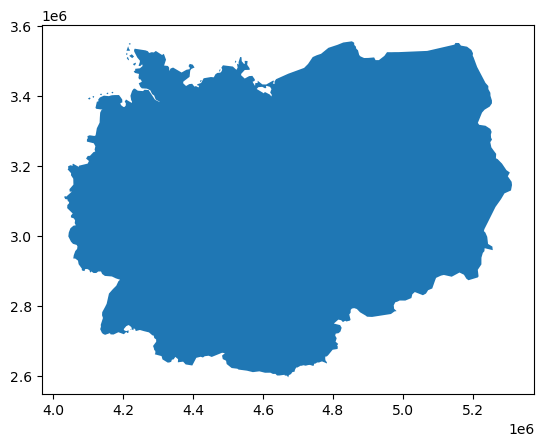

In [9]:
aoi = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1994_political")
aoi = aoi.dissolve()
aoi.plot()

In [10]:
def get_building_counts_per_region(buildings, boundary, level="level_4"):
    joined = gpd.sjoin(buildings, boundary, how="left", predicate="within")
    grouped = joined.groupby("NAME")[level].value_counts()
    cnt_table = pd.DataFrame(grouped.unstack().fillna(0).T)
    
    return cnt_table

In [11]:
def normalize_building_counts(count_table):
    region_building_sums = count_table.sum(axis=0)
    cnt_table_norm = count_table.div(region_building_sums, axis=1)
    return cnt_table_norm

In [12]:
def generate_bc_heatmaps_for_boundary(level_list, boundary_name):

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.flatten()
    
    for level, ax in zip(level_list, axs):
        bc = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_{level}.pq')
        sns.heatmap(bc, annot=True, ax=ax)
        ax.set_title(level)

    fig.suptitle(boundary_name)
    fig.tight_layout()

Outliers on rows 3,4,10 on level 4

In [13]:
def compute_bc_matrix(count_table):
    num_regions = len(count_table.columns)
    bray_curtis_matrix = np.zeros((num_regions, num_regions))

    for i in range(num_regions):
        for j in range(num_regions):
            if i != j:
                reg_i = count_table.iloc[:,i]
                reg_j = count_table.iloc[:,j]
                bray_curtis_matrix[i,j] = distance.braycurtis(reg_i, reg_j)

    bray_curtis_matrix = pd.DataFrame(bray_curtis_matrix, index=count_table.columns, columns=count_table.columns)
    return bray_curtis_matrix

In [14]:
def generate_bc_matrices(boundary_list, level_list):
    for bnd in boundary_list:
        boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        
        for level in level_list:
            building_counts = get_building_counts_per_region(buildings, boundary, level)
            building_counts_norm = normalize_building_counts(building_counts)
            
            bray_curtis_matrix = compute_bc_matrix(building_counts_norm)
    
            bray_curtis_matrix.to_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_{level}.pq')

In [15]:
def generate_boundary_diagram(boundary_name, ax):
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=boundary_name)

    bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{boundary_name}_level_4.pq')
    
    indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
    left, right = np.unique(np.sort(indices, axis=0), axis=1)

    mask = left == right
    left = left[~mask]
    right = right[~mask]
    geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
    left = boundary.NAME.iloc[left]
    right = boundary.NAME.iloc[right]
    border_widths = []
    for l, r in zip(left, right):
        border_widths.append(bray_curtis_matrix.loc[l, r])
        
    #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
    #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
    border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]

    for geom, width in zip (geoms, border_widths):
        gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color="black", alpha=0.9)
        # print(geom)
    ax.set_title(f"{boundary_name}")

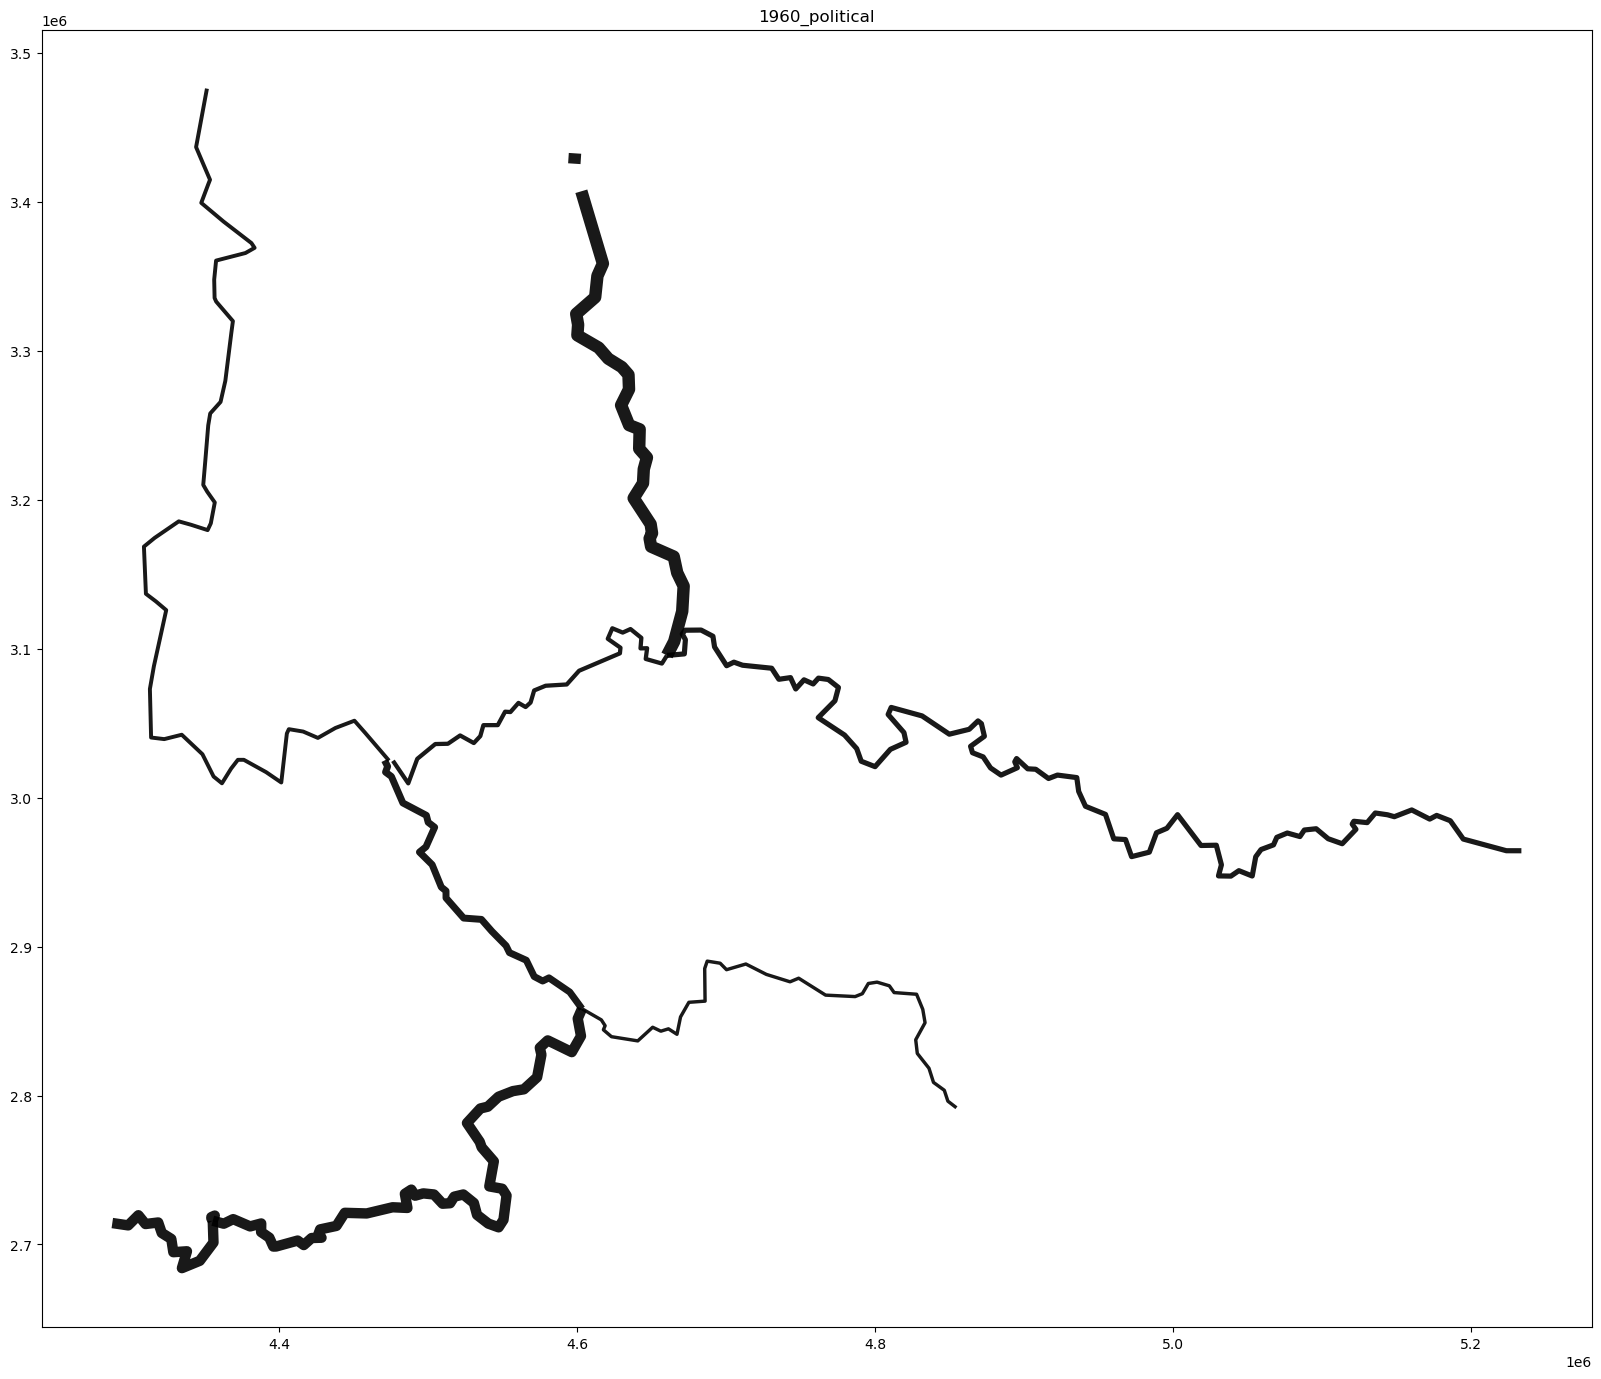

In [16]:
fig, ax = plt.subplots(figsize=(20,20))
generate_boundary_diagram("1960_political", ax=ax)

In [17]:
def generate_boundary_diagrams(boundary_lst):
    
    fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(20,10), sharex=True, sharey=True)
    axs = axs.flatten()
    #aoi.plot(ax=ax[0], color='lightgray')
    #aoi.plot(ax=ax[1], color='lightgray')
    #cmap = plt.get_cmap("tab20")
    #colors = {bnd: cmap(i) for i,bnd in enumerate(boundary_lst)}
    
    for i, boundary in enumerate(boundary_list):
        aoi.plot(ax=axs[i], color='lightgray')
        generate_boundary_diagram(boundary, ax=axs[i])

    plt.tight_layout()
        #print(bnd)
        #boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
        #bray_curtis_matrix = pd.read_parquet(f'/data/uscuni-ulce/boundaries_of_change/bc_matrices/bc_{bnd}_level_4.pq')

        #indices = boundary.sindex.query(boundary.geometry, predicate="intersects")
        #left, right = np.unique(np.sort(indices, axis=0), axis=1)

        #mask = left == right
        #left = left[~mask]
        #right = right[~mask]
        #geoms = boundary.iloc[left].intersection(boundary.iloc[right], align=False)
        #left = boundary.NAME.iloc[left]
        #right = boundary.NAME.iloc[right]

        #border_widths = []

        #for l, r in zip(left, right):
        #    border_widths.append(bray_curtis_matrix.loc[l, r])
            
        #alphas = [(4*(np.exp(2*a) - 1)) for a in border_widths]
        #alphas = [(a - min(alphas)) / (max(alphas) - min(alphas)) for a in alphas]
        #border_widths = [(0.1 + 4*(np.exp(2*w) - 1)) for w in border_widths]

        #from matplotlib.patches import Patch
        #patches_legend = [Patch(facecolor=colors[bnd], label=bnd) for bnd in boundary_lst]

        #for geom, width, alpha in zip (geoms, border_widths, alphas):
        #    gpd.GeoSeries([geom]).plot(ax=ax[0], linewidth=width, color=colors[bnd], alpha=alpha)
        #    ax[0].legend(handles=patches_legend)


        #    gpd.GeoSeries([geom]).plot(ax=ax[1], linewidth=width, color="black", alpha=alpha)
            #ax.legend(handles=patches_legend)
    for ax in axs:
        ax.set_axis_off()

/tmp/ipykernel_259185/3632078295.py:24: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  gpd.GeoSeries([shapely.line_merge(geom)]).plot(ax=ax, linewidth=width, color="black", alpha=0.9)


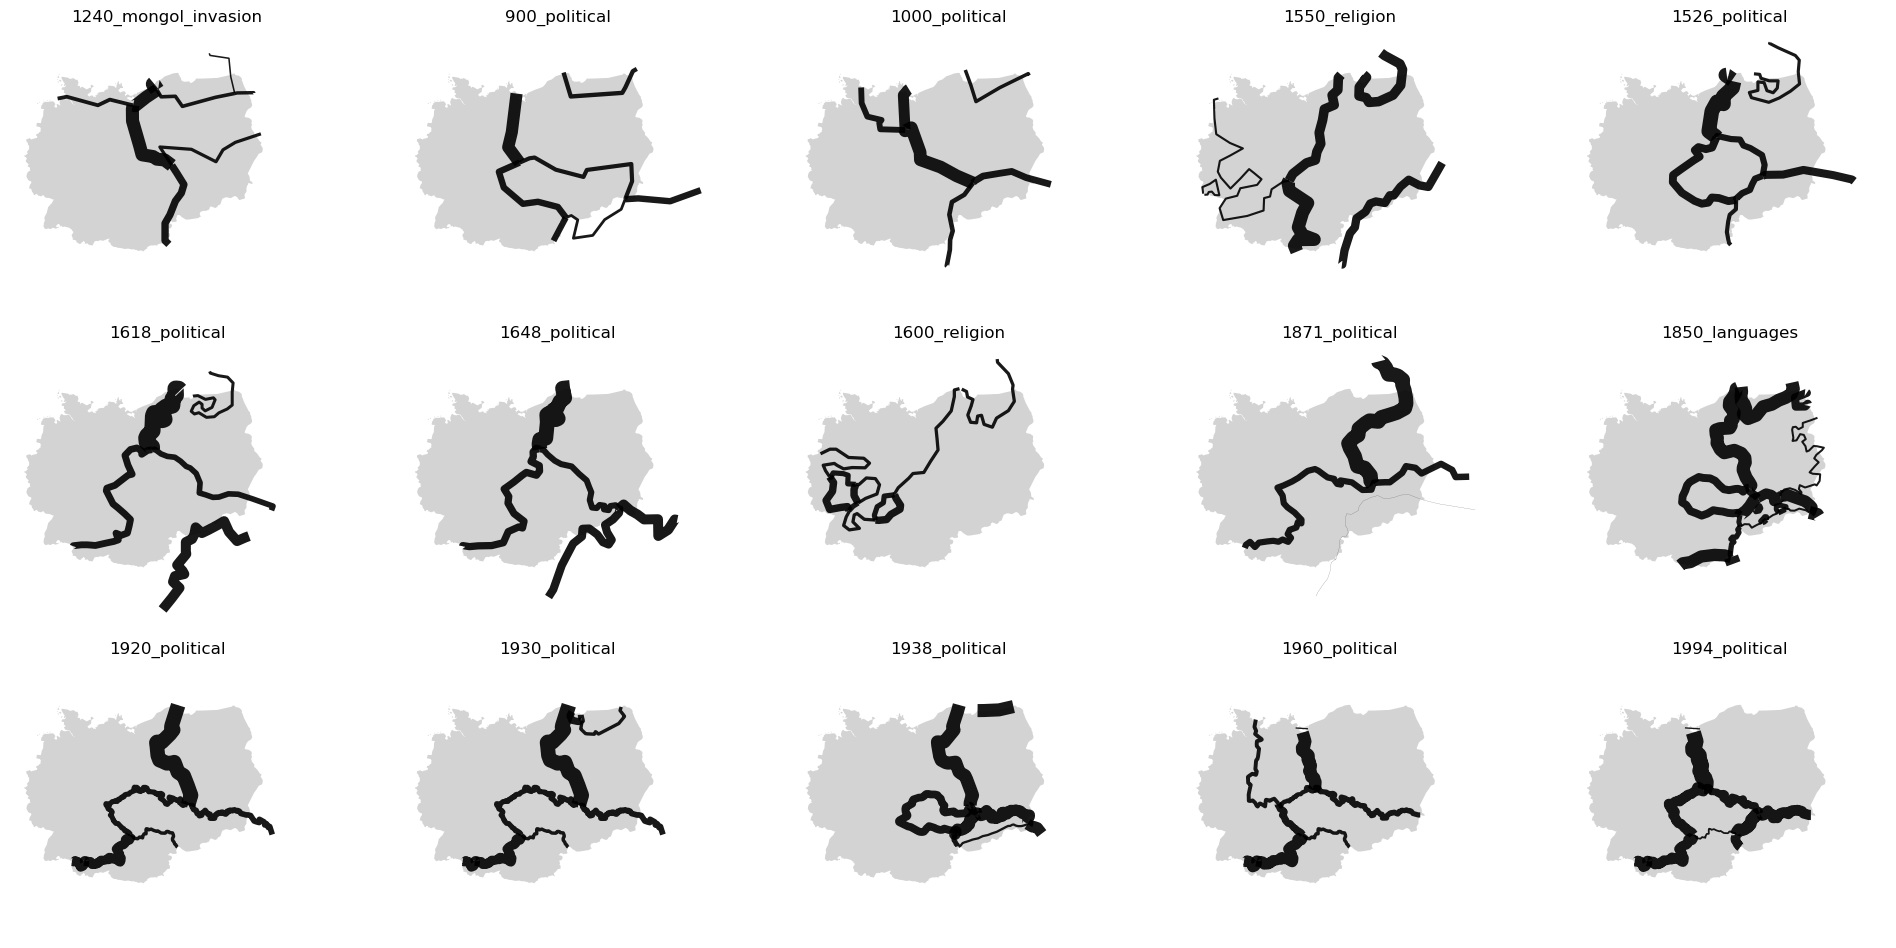

In [18]:

generate_boundary_diagrams(boundary_list)

## Gridding and clustering

In [20]:
import libpysal
import spopt
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate

In [21]:
boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer="1960_political")

In [30]:
hexed = h3fy(boundary, resolution=6)

/home/dancejod/boundaries_of_change/.pixi/envs/default/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Text(0.5, 1.0, 'Hexxd')

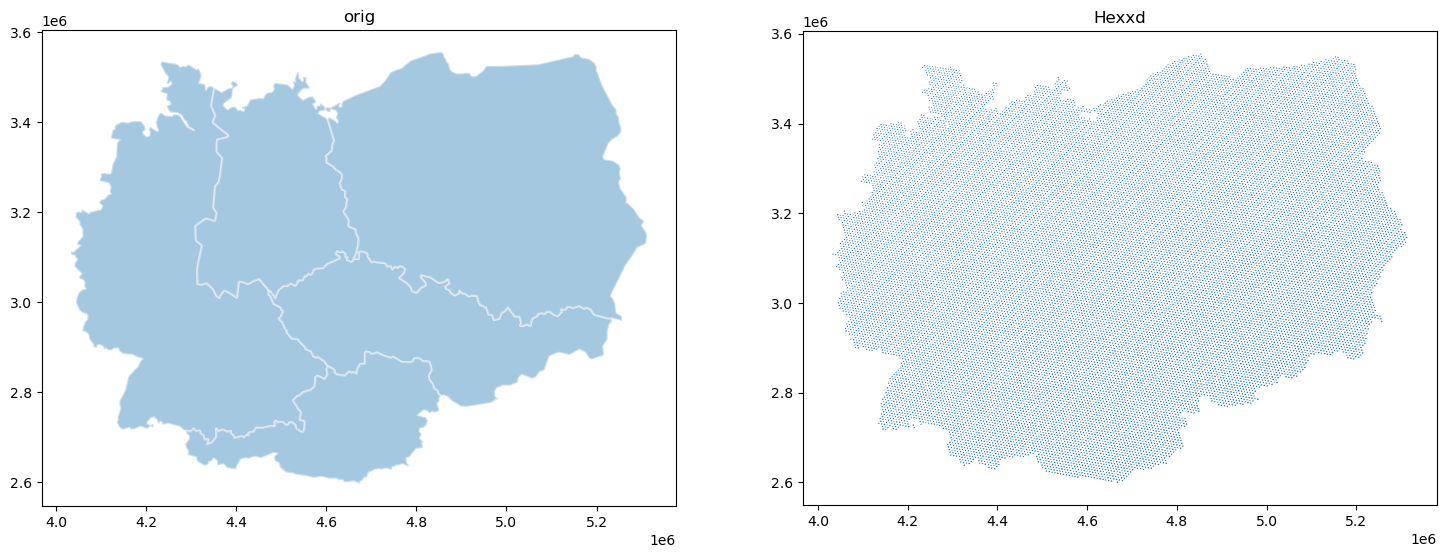

In [40]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

boundary.plot(ax=axs[0], alpha=0.4, linewidth=1.6, edgecolor='white')
hexed.plot(ax=axs[1], alpha=1,  edgecolor='white')

axs[0].set_title('orig')
axs[1].set_title('Hexxd')


In [32]:
hexed

,geometry
hex_id,
861e256b7ffffff,"POLYGON ((4888570.83 3215216.132, 4889409.402 ..."
861f0895fffffff,"POLYGON ((4739780.687 3484577.597, 4742424.465..."
861f1b8c7ffffff,"POLYGON ((4596253.998 3156323.265, 4599809.112..."
861f0264fffffff,"POLYGON ((4430953.348 3352341.959, 4430041.724..."
861e3230fffffff,"POLYGON ((4611442.984 2837925.418, 4608732.852..."
...,...
861e152dfffffff,"POLYGON ((4811661.159 2730287.059, 4814438.843..."
861e28247ffffff,"POLYGON ((5213234.42 3106811.708, 5214019.279 ..."
861f0b4efffffff,"POLYGON ((4796182.885 3315034.02, 4798870.432 ..."


In [33]:
hexed.index.name = "NAME"

In [48]:
hex_w_buildings = get_building_counts_per_region(buildings, hexed, level="level_4")

In [34]:
    joined = gpd.sjoin(buildings, hexed, how="left", predicate="within")
    # grouped = joined.groupby("NAME")[level].value_counts()
    # cnt_table = pd.DataFrame(grouped.unstack().fillna(0).T)

In [38]:
data = joined.groupby("NAME")["level_4"].value_counts().unstack().fillna(0)

In [39]:
data

level_4,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
NAME,,,,,,,,,,,,,,,,
861e00007ffffff,0.0,0.0,0.0,0.0,214.0,179.0,436.0,1757.0,0.0,0.0,0.0,439.0,0.0,484.0,12.0,0.0
861e0000fffffff,0.0,0.0,0.0,0.0,0.0,59.0,151.0,97.0,0.0,0.0,0.0,64.0,0.0,105.0,0.0,0.0
861e00017ffffff,1105.0,0.0,0.0,0.0,599.0,1081.0,810.0,2073.0,0.0,0.0,0.0,75.0,0.0,1136.0,161.0,485.0
861e0001fffffff,0.0,0.0,0.0,0.0,0.0,197.0,5.0,772.0,0.0,0.0,0.0,461.0,0.0,617.0,10.0,0.0
861e00027ffffff,0.0,0.0,0.0,0.0,0.0,0.0,187.0,466.0,0.0,0.0,0.0,142.0,6.0,205.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861faed97ffffff,0.0,0.0,0.0,0.0,0.0,13.0,416.0,1188.0,0.0,0.0,0.0,0.0,0.0,110.0,0.0,0.0
861faed9fffffff,188.0,0.0,0.0,0.0,0.0,399.0,638.0,754.0,0.0,0.0,0.0,0.0,0.0,458.0,0.0,0.0
861faeda7ffffff,0.0,0.0,0.0,0.0,155.0,196.0,127.0,1819.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,0.0


In [47]:
test = spopt.region.maxp.maxp(hex_w_building_counts)

TypeError: maxp() missing 5 required positional arguments: 'w', 'attrs_name', 'threshold_name', 'threshold', and 'top_n'

## Bray-Curtis

In [19]:
bray_curtis_matrix =compute_bc_matrix(cnt_table_norm)

NameError: name 'cnt_table_norm' is not defined

In [ ]:
sns.heatmap(bray_curtis_matrix, annot=True)

In [ ]:
generate_bc_matrices(boundary_list, level_columns)

## Draw borders

In [ ]:
for bnd in boundary_list:
    boundary = gpd.read_file("/data/uscuni-ulce/boundaries_of_change/impact_boundaries.gpkg", layer=bnd)
    joined = gpd.sjoin(buildings, boundary, how="left", predicate="within")
    generate_bc_heatmaps_for_boundary(level_columns, bnd)

In [ ]:
indices = boundaries.sindex.query(boundaries.geometry, predicate="intersects")
left, right = np.unique(np.sort(indices, axis=0), axis=1)

mask = left == right
left = left[~mask]
right = right[~mask]
geoms = boundaries.iloc[left].intersection(boundaries.iloc[right], align=False)
left = boundaries.NAME.iloc[left]
right = boundaries.NAME.iloc[right]

geoms.plot(cmap='tab20')

In [ ]:
geoms

In [ ]:
bray_curtis_matrix.loc[left.iloc[0],right.iloc[0]]

In [ ]:
geoms = gpd.GeoDataFrame(geometry=geoms)

In [ ]:
border_widths = []

for l, r in zip(left, right):
    border_widths.append(bray_curtis_matrix.loc[l, r])


In [ ]:
geoms["width"] = [np.sqrt(w) for w in border_widths]
geoms

In [ ]:
widths = (geoms.width - geoms.width.min()) / (geoms.width.max() - geoms.width.min())

geoms["map_width"] = widths
geoms

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
aoi.plot(ax=ax, color='lightgray')

geoms.plot(ax=ax, linewidth=geoms["map_width"], color='red')

## Principal Coordinates visualization

In [ ]:
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix

In [ ]:
pcoa_res = pcoa(DistanceMatrix(bray_curtis_matrix, ids=cnt_table_norm.columns))

In [ ]:
pcoa_res_df = pd.DataFrame(pcoa_res.samples.iloc[:, :2], index=cnt_table_norm.columns)

In [ ]:
pcoa_res_df

In [ ]:
sns.scatterplot(x="PC1", y="PC2", hue=pcoa_res_df.index, data=pcoa_res_df, s=100)